This Notebooks shows how to load a `seillra` model and use it to caluclate chromatin features.
It also shows how to access chromatin feature annotation, and how to calculate sequence classes.

**STEP 1:** 

Import `seillra` and other packages:

In [1]:
import os, sys
import pandas as pd
import torch
import numpy as np
import collections

import seillra as sl

**STEP 2:**

- Decide on rank of approximate linear layers: 64
- Decide on the output type: chromatin profiles 
    - `projection = False` d=231,907 chromatin features 
    - `projection = True` d=61 sequence classes of which typically only the first 40 are used
- Decide on the device to use for inference (CPU)
- If inference is on arm64 hardware (e.g. macbook), use `qnnpack` as backend if `quant == "CPU"`
- If `quant == "GPU_int8"` use a batch size of 32.

Then load the according model.

In [2]:
import platform

# - what model to load
rank = 64
sequence_classes = False  # True
sequence_type = "sequence"  # "variant"
quant = "CPU"  # None, "GPU_fp16", "GPU_int8"
projection = False  # True; Fasle will give 21,907 chromatin features


# - CPU quantization backend
if quant == "CPU":
    if platform.machine() == "arm64":
        if "qnnpack" in torch.backends.quantized.supported_engines:
            torch.backends.quantized.engine = "qnnpack"
        else:
            raise RuntimeError("QNNPACK not supported on this arm64 machine.")
    if platform.machine() == "x86_64":
        if "fbgemm" in torch.backends.quantized.supported_engines:
            torch.backends.quantized.engine = "fbgemm"
        else:
            raise RuntimeError("FBGEMM not supported on this x86_64 machine.")
    print("Using quantized engine:", torch.backends.quantized.engine)

# - load the model
model = sl.Sei_LLRA(k=rank, projection=False, mode=sequence_type, quant=quant)

Using quantized engine: fbgemm


2026-01-23 13:41:30,700 - INFO - Checksum verified for url_a6038b62128b5b01_wts: 28a1a49ca62e4d67a62c170df3751f7255db6eea3923455c119c762dde446308
2026-01-23 13:41:30,701 - INFO - Loading state dict from /home/ejg66/.cache/seillra/1.5/url_a6038b62128b5b01_wts
2026-01-23 13:41:30,927 - INFO - Model weights loaded and set to eval mode.
2026-01-23 13:41:31,138 - INFO - Checksum verified for url_b9a0eb4608886e0d_wts: e50fe852023657a60952698c591b291df0e4db3111a0e8ea122546f70eee27c3
2026-01-23 13:41:31,138 - INFO - Loading state dict from /home/ejg66/.cache/seillra/1.5/url_b9a0eb4608886e0d_wts
2026-01-23 13:41:31,230 - INFO - Model weights loaded and set to eval mode.


In [5]:
model = sl.Sei_LLRA(k=rank, projection=False, mode=sequence_type, quant=None)
print(model.device)
model = model.to(torch.device("cpu"))
print(model.device)

sequences = torch.randint(0, 4, (16, 4096))
x = torch.nn.functional.one_hot(sequences, num_classes=4).permute(0, 2, 1).float()
print(x.device)
y = model(x)
print(y.shape)


2026-01-23 13:44:35,686 - INFO - Checksum verified for url_0fe8ae95432a4966_wts: 346677580a9bfcdab1bc83735e12c17c8f5d2ec76eb91a45b4e3b2a91f59bf40
2026-01-23 13:44:35,687 - INFO - Loading state dict from /home/ejg66/.cache/seillra/1.5/url_0fe8ae95432a4966_wts
2026-01-23 13:44:35,790 - INFO - Model weights loaded and set to eval mode.
2026-01-23 13:44:35,933 - INFO - Checksum verified for url_cc50b7cd539e94b0_wts: 7fd1f2ee86a83e8a985dff13a1164c9f32a0fcb60f8309d38019e1ad17797d35
2026-01-23 13:44:35,939 - INFO - Loading state dict from /home/ejg66/.cache/seillra/1.5/url_cc50b7cd539e94b0_wts
2026-01-23 13:44:35,953 - INFO - Model weights loaded and set to eval mode.


cuda
cuda
cpu
torch.Size([16, 21907])


(See the readme file for loading the Sei model components (trunk, head, projection) seperately)

**STEP 3:**

Use the model to predict sequence classes (since we indlucded the projection model for DNA input sequences):

- Generate 16 random input sequences
- Apply the `seillra` model
- Print (part of) the result

In [3]:
# - random 1-hot sequences
sequences = torch.randint(0, 4, (16, 4096))
x = torch.nn.functional.one_hot(sequences, num_classes=4).permute(0, 2, 1).float()

# - run the model
out = model(x.to("cpu"))

# - typically discard the "unintersting" sequence classes (see the original Sei repository/paper)
res = out[:, :22]

# - Sequence class scores for the first 3 sequences and first 11 classes
print(res[:3, :11])

tensor([[5.1939e-04, 3.3409e-03, 2.8054e-03, 1.0129e-03, 8.1243e-04, 4.5710e-03,
         8.3276e-03, 1.8325e-04, 1.3995e-04, 1.4276e-04, 3.8486e-04],
        [3.4644e-04, 2.9107e-03, 1.7275e-03, 1.8521e-03, 1.9300e-03, 8.3276e-03,
         1.3028e-02, 8.5965e-04, 6.2070e-04, 3.7089e-04, 1.6628e-03],
        [9.4300e-05, 2.3493e-03, 3.3013e-04, 1.5723e-03, 5.6506e-04, 2.8737e-03,
         4.7738e-03, 2.6018e-04, 2.3310e-04, 9.4147e-05, 6.7857e-04]])


**STEP 4:**

Plot a heatmap with sequence class annotations.

In [4]:
model.projection

False

Target annotations: (21907, 3):

                         context  assay     info
0         HeLa_Epithelium_Cervix  BTAF1     ID:1
1  H9_Embryonic_Stem_Cell_Embryo  EOMES  ID:1006
2  H9_Embryonic_Stem_Cell_Embryo  EP300  ID:1007
3  H9_Embryonic_Stem_Cell_Embryo  FOXH1  ID:1010
4  H9_Embryonic_Stem_Cell_Embryo  FOXH1  ID:1011
5  H9_Embryonic_Stem_Cell_Embryo  FOXP1  ID:1012
6  H9_Embryonic_Stem_Cell_Embryo  FOXP1  ID:1013


Text(0.5, 1.0, 'Heatmap for 16 sequences and first 22 chromatin features')

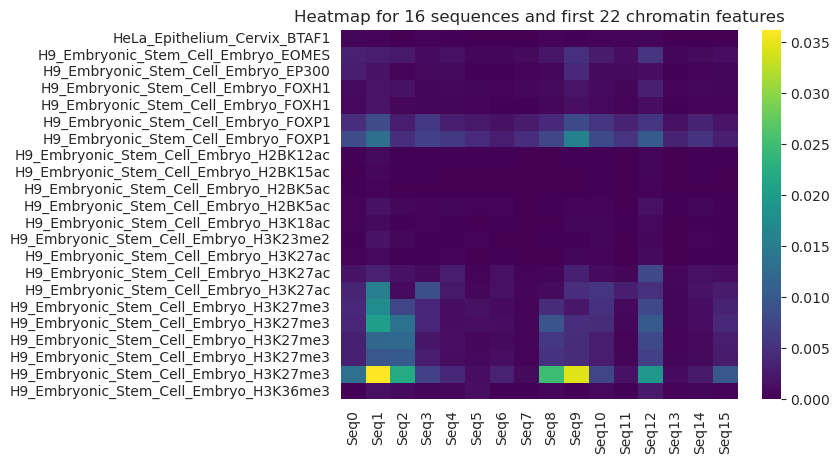

In [ ]:
import pandas as pd

tgts = pd.DataFrame(model.head.target_annot)
print(f"Target annotations: {tgts.shape}:\n")
print(tgts.head(7))

# - make a heatmap of res for the first 55 seqs and 100 chromatin features
# - use sequences on the y-axis (and label accordingly)
# - use chromatin features on the x-axis (and label accordingly)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.heatmap(
    res.cpu().detach().numpy().T,
    yticklabels=tgts["context"][:22] + "_" + tgts["assay"][:22],
    xticklabels=[f"Seq{i}" for i in range(16)],
    cmap="viridis",
    vmin=0,
    vmax=res[:16, :22].max().item(),
)
plt.title("Heatmap for 16 sequences and first 22 chromatin features", fontsize=12)

**STEP 5:**

Project the chromatin profiles onto sequence classes. 
Keep only the first 40 ("meaningful") classes

In [6]:
projmod = sl.get_sei_projection(quant="CPU")
seq_classes = projmod(out)  # - re-use out from above
cls = seq_classes[:, :40]
print("\nSequence class scores for the first 7 sequences and first 11 classes:")
print(cls[:7, :11])

2026-01-21 14:57:30,796 - INFO - Checksum verified for url_f6f3b1c27e97399e_wts: ba3e530e53694c66a9573c0a38e0915986b95f19b99a962f357997eadaa33d44
2026-01-21 14:57:30,804 - INFO - Loading state dict from /home/ejg66/.cache/seillra/1.5/url_f6f3b1c27e97399e_wts
2026-01-21 14:57:30,809 - INFO - Model weights loaded and set to eval mode.



Sequence class scores for the first 7 sequences and first 11 classes:
tensor([[0.7864, 1.1795, 0.3932, 0.5898, 0.5898, 1.1795, 1.3761, 0.9830, 0.5898,
         2.1625, 0.7864],
        [1.1795, 1.1795, 0.3932, 0.5898, 0.5898, 1.3761, 1.7693, 1.1795, 0.7864,
         2.5557, 0.7864],
        [0.5898, 0.7864, 0.3932, 0.3932, 0.3932, 0.7864, 0.9830, 0.7864, 0.3932,
         1.9659, 0.3932],
        [0.3932, 0.3932, 0.1966, 0.1966, 0.1966, 0.5898, 0.7864, 0.3932, 0.3932,
         1.1795, 0.1966],
        [0.3932, 0.3932, 0.1966, 0.3932, 0.1966, 0.7864, 0.9830, 0.5898, 0.1966,
         1.5727, 0.3932],
        [0.1966, 0.1966, 0.0000, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
         0.1966, 0.1966],
        [0.1966, 0.3932, 0.1966, 0.1966, 0.1966, 0.3932, 0.5898, 0.3932, 0.1966,
         0.9830, 0.1966]])


Next, make a heatmap again, with sequence class annotation.

Text(0.5, 1.0, 'Heatmap for 16 sequences and first 40 sequence classes')

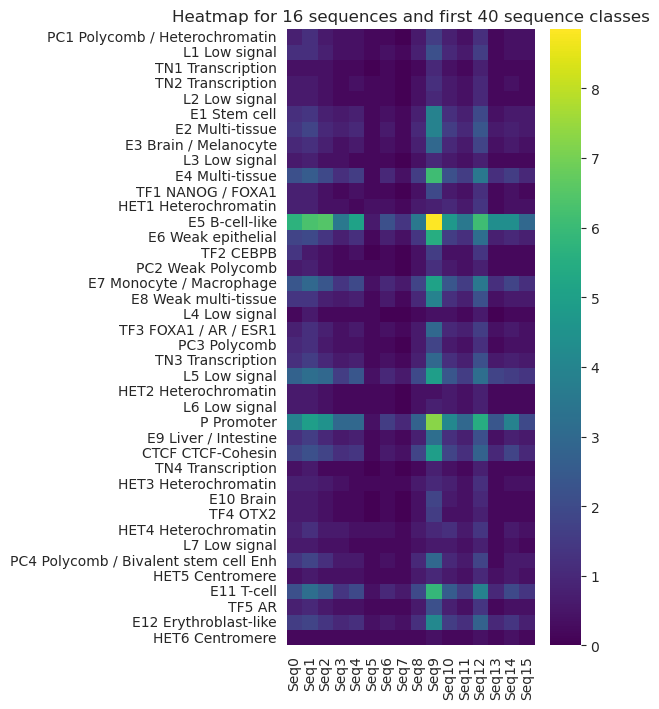

In [7]:
# - heatmap of the sequence classes
plt.figure(figsize=(4, 8))
sns.heatmap(
    cls.cpu().detach().numpy().T,
    # yticklabels=[f"Class{i}" for i in range(40)],
    yticklabels=projmod.class_annot,
    xticklabels=[f"Seq{i}" for i in range(16)],
    cmap="viridis",
    vmin=0,
    vmax=cls[:16, :40].max().item(),
)
plt.title("Heatmap for 16 sequences and first 40 sequence classes", fontsize=12)